In [2]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_extraction import DictVectorizer

### Q1. Downloading the data

In [3]:
df_jan = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")

In [4]:
print(df_jan.shape)

(3066766, 19)


Read the data for January. How many columns are there? **16**

### Q2. Computing duration

In [5]:
df_jan["duration"] = df_jan.tpep_dropoff_datetime - df_jan.tpep_pickup_datetime
df_jan.duration = df_jan.duration.apply(lambda x: x.total_seconds()/60)


In [6]:
df_jan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [7]:
df_jan.duration.std()

42.594351241920904

What's the standard deviation of the trips duration in January? **42**

### Q3. Dropping outliers

/tmp/ipykernel_94584/1995654764.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_jan.duration)


<Axes: xlabel='duration', ylabel='Density'>

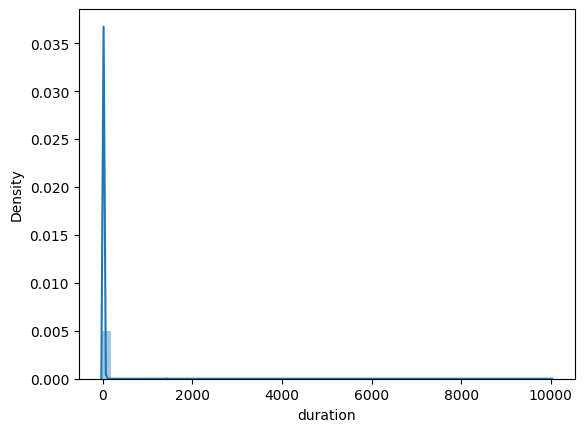

In [8]:
sns.distplot(df_jan.duration)

In [9]:
((df_jan.duration>=1) & (df_jan.duration<=60)).mean()

0.9812202822125979

In [10]:
df_jan_filtered = df_jan[(df_jan.duration>=1) & (df_jan.duration<=60)]

What fraction of the records left after you dropped the outliers? **98%**

### Q4. One-hot encoding

In [11]:
df_jan_filtered.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [12]:
cat_features = ["PULocationID", "DOLocationID"]
num_features = ["trip_distance"]

In [13]:
df_jan_filtered[cat_features] = df_jan_filtered[cat_features].astype(str)

/tmp/ipykernel_94584/4280539919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jan_filtered[cat_features] = df_jan_filtered[cat_features].astype(str)


In [14]:
dv = DictVectorizer()
df_jan_dict = df_jan_filtered[cat_features].to_dict(orient="records")

In [15]:
x_train = dv.fit_transform(df_jan_dict)

In [16]:
x_train.shape

(3009173, 515)

What's the dimensionality of this matrix (number of columns)? **515**

In [17]:
target = "duration"
y_train = df_jan_filtered[target].values

### Q5. Training a model

In [18]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [19]:
y_pred = lr.predict(x_train)

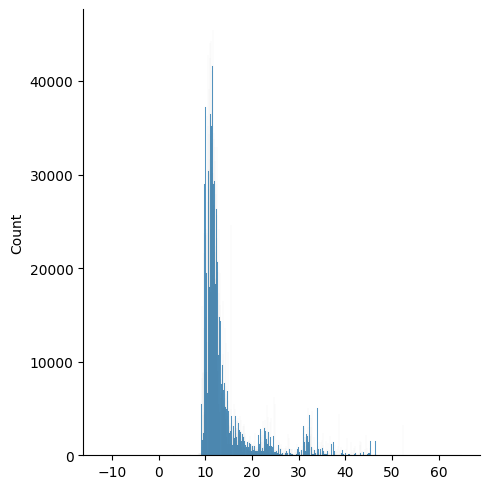

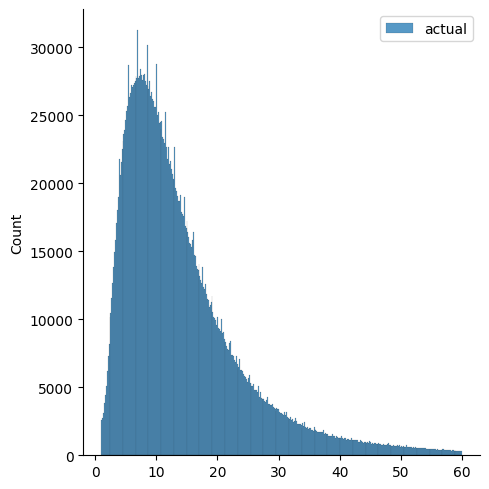

In [20]:
sns.displot(y_pred, label="prediction")
sns.displot(y_train, label="actual")

plt.legend()

In [21]:
rmse = root_mean_squared_error(y_train, y_pred)
print(rmse)

7.649261959465432


What's the RMSE on train? **7.64**

In [22]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda x: x.total_seconds()/60)
    
    df_filtered = df[(df.duration>=1) & (df.duration<=60)]
    
    cat_features = ["PULocationID", "DOLocationID"]
    df_filtered[cat_features] = df_filtered[cat_features].astype(str)
    
    return df_filtered

### Q6. Evaluating the model

In [23]:
df_feb = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")

/tmp/ipykernel_94584/3364335011.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[cat_features] = df_filtered[cat_features].astype(str)


In [24]:
val_dict = df_feb[cat_features].to_dict(orient="records")
x_val = dv.transform(val_dict)

target = "duration"
y_val = df_feb[target].values

y_pred = lr.predict(x_val)
rmse = root_mean_squared_error(y_val, y_pred)

print(rmse)

7.811818882650574


What's the RMSE on validation? **7.81**

### Save model

In [26]:
with open("../models/lin_reg_intro.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)